In [2]:
import pandas as pd
df = pd.read_csv('twitter-train.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


# We cannot tokenize first, tokenization first can lead to removing #Hastag and #Users

In [3]:
import re
import nltk
from nltk.tokenize import TreebankWordTokenizer

print('Analizing 1 sentence')
print(df.loc[0]['tweet'])
tokenizer = TreebankWordTokenizer()
tokenized_words = tokenizer.tokenize(df.loc[0]['tweet'])
print('Tokenized Words', tokenized_words)

Analizing 1 sentence
 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
Tokenized Words ['@', 'user', 'when', 'a', 'father', 'is', 'dysfunctional', 'and', 'is', 'so', 'selfish', 'he', 'drags', 'his', 'kids', 'into', 'his', 'dysfunction.', '#', 'run']


In [4]:
import nltk
from nltk.stem import WordNetLemmatizer

def find_pos(word):
    # Part of Speech constants
    # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
    pos= nltk.pos_tag(nltk.word_tokenize(word))[0][1]
    # Adjective tags -'JJ', 'JJR', 'JJS'
    if pos.lower()[0] == 'j':
        return 'a'
    # Adverb tags -'RB', 'RBR', 'RBS'
    elif pos.lower()[0] == 'r':
        return 'r'
    # Verb tags -'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
    elif pos.lower()[0] == 'v':
        return 'v'
    # Noun tags -'NN', 'NNS', 'NNP', 'NNPS'
    else:
        return 'n'
    
# Function to apply lemmatization to a list of words
def words_lemmatizer(text, encoding="utf8"):
    words = nltk.word_tokenize(text)
    lemma_words = []
    wl= WordNetLemmatizer()
    for word in words:
        pos= find_pos(word)
        lemma_words.append(wl.lemmatize(word, pos))
    return " ".join(lemma_words)

In [5]:
"""
def preprocessing(text):
    text_lower_case = lower_case(text)
    text_remove_space = remove_space(text)
    #text_remove_stop = remove_stop_words(text)
    text_lemantize   = lemattization(text)
    text_unecessary  = remove_unknown_charectors(text)
"""

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords

def remove_stopwords(text, lang='english'):
    words = nltk.word_tokenize(text)
    lang_stopwords = stopwords.words(lang)
    stopwords_removed = [w for w in words if w.lower() not in lang_stopwords]
    return " ".join(stopwords_removed)

# Converting to lower case
def do_prepocessing(one_row):
    lower_text = one_row.lower()
    
    remove_unwanted_charectors = re.sub(r'[^a-zA-Z0-9_#@&\s]', ' ', lower_text) # Remove unwated charectors like punctuations andnon ascii 
    remove_unwanted_charectors = re.sub(r'&[\w]+', ' ', remove_unwanted_charectors) # Remove &amp, *&words etc
    
    removed_extra_space = re.sub(r'\s+',' ', remove_unwanted_charectors) # Remove extra white_spaces
    
    extract_hash = re.findall(r'#[\w]+', removed_extra_space) # Extract #hashTags
    extract_has_joined = " ".join(extract_hash)
    removed_hash_text = re.sub(r'#[\w]+', '', removed_extra_space) # Remove #hastags
    
    remove_atrate = re.findall(r'@[\w]+', removed_hash_text) # Extract @Users
    count = len(remove_atrate)
    removed_atrate = re.sub(r'@[\w]+', '', removed_hash_text) # Remove @Users
    
    removed_stopwords_text = remove_stopwords(removed_atrate)
    lemmatize_text = words_lemmatizer(removed_stopwords_text)
    #print("count=", count, "# text = ", extract_has_joined, "Actual text ",lemmatize_text )
    return count, extract_has_joined, lemmatize_text

df_train = pd.read_csv('twitter-train.csv', index_col='id')

new_df = df_train['tweet'].apply(do_prepocessing)
print(new_df.head())

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dipik\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dipik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


id
1    (1, #run, father dysfunctional selfish drag ki...
2    (2, #lyft #disapointed #getthanked, thanks cre...
3                                (0, , bihday majesty)
4                   (0, #model, love u take u time ur)
5                 (0, #motivation, factsguide society)
Name: tweet, dtype: object


In [6]:
count_rates = []
hash_tags = []
tweet_values = []

for tuple_extract in new_df.values:
    count_rates.append(tuple_extract[0])
    hash_tags.append(tuple_extract[1])
    tweet_values.append(tuple_extract[2])
    
print(count_rates[:10])
print(hash_tags[:10])
print(tweet_values[:10])

[1, 2, 0, 0, 0, 0, 8, 0, 0, 2]
['#run', '#lyft #disapointed #getthanked', '', '#model', '#motivation', '#allshowandnogo', '', '#school #exams #hate #imagine #actorslife #revolutionschool #girl', '#allin #cavs #champions #cleveland #clevelandcavaliers', '#gr8']
['father dysfunctional selfish drag kid dysfunction', 'thanks credit use cause offer wheelchair van pdx', 'bihday majesty', 'love u take u time ur', 'factsguide society', '2 2 huge fan fare big talk leave chaos pay dispute get', 'camp tomorrow danny', 'next school year year exam think', 'love land', 'welcome']


In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

new_frame = pd.DataFrame({'label':df_train['label'].values, 'Count':count_rates, 'HashTag': hash_tags, 'text': tweet_values})
print(new_frame.head())

ones_flag = new_frame['label'] == 1

plt.figure(figsize=(20, 20))
one_text = " ".join(new_frame['text'][ones_flag].values)
print(len(one_text))
wordcloud  = WordCloud().generate(one_text)

plt.subplot(1, 2, 1)
plt.imshow(wordcloud)
plt.title("Most frequently occuring words in label 1")
plt.axis("off")

zero_text = " ".join(new_frame['text'][ones_flag == False].values)
print(len(zero_text))
wordcloud  = WordCloud().generate(zero_text)
plt.subplot(1, 2, 2)
plt.imshow(wordcloud)
plt.title("Most frequently occuring words in label 0")
plt.axis("off")

   label  Count                         HashTag  \
0      0      1                            #run   
1      0      2  #lyft #disapointed #getthanked   
2      0      0                                   
3      0      0                          #model   
4      0      0                     #motivation   

                                                text  
0  father dysfunctional selfish drag kid dysfunction  
1   thanks credit use cause offer wheelchair van pdx  
2                                     bihday majesty  
3                              love u take u time ur  
4                                 factsguide society  
84426
977439


(-0.5, 399.5, 199.5, -0.5)

48376
669298


(-0.5, 399.5, 199.5, -0.5)

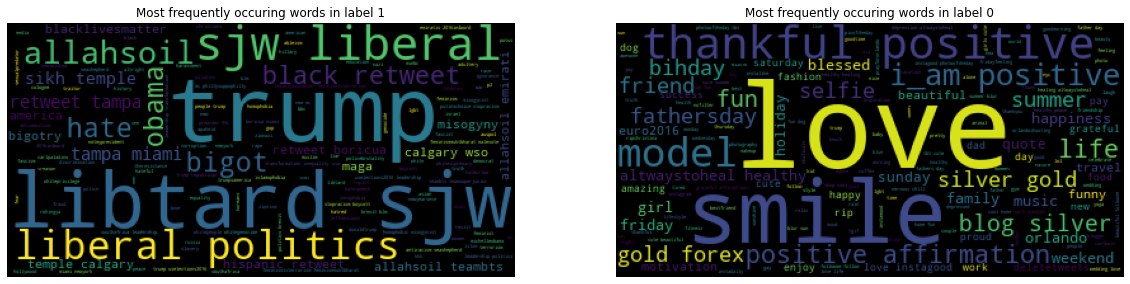

In [9]:
plt.figure(figsize=(20, 20))
one_hash_text = " ".join(new_frame['HashTag'][ones_flag].values)
print(len(one_hash_text))
wordcloud  = WordCloud().generate(one_hash_text)

plt.subplot(1, 2, 1)
plt.imshow(wordcloud)
plt.title("Most frequently occuring words in label 1")
plt.axis("off")

zero_hash_text = " ".join(new_frame['HashTag'][ones_flag == False].values)
print(len(zero_hash_text))
wordcloud  = WordCloud().generate(zero_hash_text)

plt.subplot(1, 2, 2)
plt.imshow(wordcloud)
plt.title("Most frequently occuring words in label 0")
plt.axis("off")

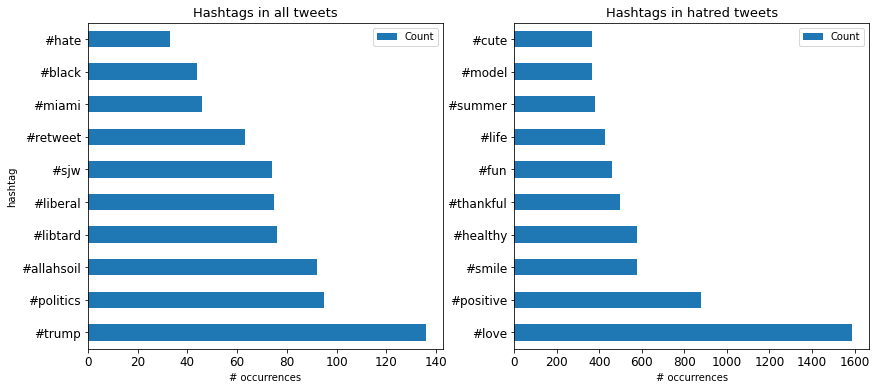

In [10]:
from nltk import FreqDist

all_hashtags = FreqDist(list(one_hash_text.split())).most_common(10)
hatred_hashtags = FreqDist(list(zero_hash_text.split())).most_common(10)

plt.figure(figsize=(14, 6))
ax = plt.subplot(121)
pd.DataFrame(all_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.title('Hashtags in all tweets', size=13)

ax = plt.subplot(122)
pd.DataFrame(hatred_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.ylabel('')
plt.title('Hashtags in hatred tweets', size=13)
plt.show()

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 3))
vectorizer.fit(new_frame['HashTag'].values)
hash_tag_feature = vectorizer.transform(new_frame['HashTag'])
print(hash_tag_feature.shape)

vectorizer_text = CountVectorizer(ngram_range=(1, 3))
vectorizer_text.fit(new_frame['text'])
text_feature = vectorizer_text.transform(new_frame['text'])
print(text_feature.shape)

from scipy.sparse import hstack
new_fe = hstack((hash_tag_feature, text_feature))

print(new_fe.shape)

(31962, 89869)
(31962, 209094)
(31962, 298963)


In [12]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_val, y_train, y_val = train_test_split(new_fe, new_frame['label'].apply(int))
print("x_train shape = ", x_train.shape)
print("y_train shape = ", y_train.shape)
print("x_val shape = ", x_val.shape)
print("y_val shape = ", y_val.shape)

x_train shape =  (23971, 298963)
y_train shape =  (23971,)
x_val shape =  (7991, 298963)
y_val shape =  (7991,)


In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

#params = {'kernel':['linear', 'rbf', 'poly'], 'gamma':['auto', 'scale'], 'C':[0.01, 0.1, 1, 10, 100]}
#svc = GridSearchCV(SVC(), param_grid=params, scoring='f1', cv=3, n_jobs=-1)
svc = SVC(kernel='linear')
svc.fit(x_train, y_train)

#print("Best model = ", svc.best_params_)
#print("Best Scores = ", svc.best_score_)

predictions = svc.predict(x_val)
print("\nF1 test score for SVC: {:.2f}".format(f1_score(y_val, predictions)))


F1 test score for SVC: 0.68


In [12]:
from sklearn.metrics import classification_report

print (classification_report(predictions, y_val))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      7654
           1       0.55      0.90      0.68       337

    accuracy                           0.96      7991
   macro avg       0.77      0.93      0.83      7991
weighted avg       0.98      0.96      0.97      7991



In [13]:
from sklearn.naive_bayes import MultinomialNB
model_nb = MultinomialNB().fit(x_train, y_train)

#print("Best model = ", svc.best_params_)
#print("Best Scores = ", svc.best_score_)

predictions_nb = model_nb.predict(x_val)
print("\nF1 test score for SVC: {:.2f}".format(f1_score(y_val, predictions_nb)))


F1 test score for SVC: 0.52
